In [97]:
import os
import glob
import dask

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.preprocessing import extract_quotes

In [6]:
DATA_PATH = '/Users/mac/Desktop/Repos/FBD_Project/datasets/'
RAW_DATA_PATH = DATA_PATH + 'raw/'

quote_btc = sorted(glob.glob(RAW_DATA_PATH + 'btcusdt/quotes/*.csv.gz'))
quote_eth = sorted(glob.glob(RAW_DATA_PATH + 'ethusdt/quotes/*.csv.gz'))
quote_ada = sorted(glob.glob(RAW_DATA_PATH + 'adausdt/quotes/*.csv.gz'))

In [108]:
@dask.delayed
def extract_quotes(quote_file_path: str) -> pd.DataFrame:
    df = pd.read_csv(quote_file_path)[
        ["timestamp", "ask_price", "bid_price", "ask_amount", "bid_amount"]
    ]
        
    # calculate mid price and bidask spread
    df["mid_price"] = (df["ask_price"] + df["bid_price"]) / 2
    df["ba_spread"] = np.round((df["ask_price"] - df["bid_price"]), 5)
    df["imbalance"] = df["bid_amount"] / (df["bid_amount"] + df["ask_amount"])
    df["timestamp"] = pd.to_datetime(df["timestamp"] / 1000, unit="ms")
    df = df.set_index("timestamp")
    
    # resample by 1second frequency
    df = df.resample("1s").last().ffill()
    return df

In [ ]:
# Sasha Stoikov (2018) The micro-price: a high-frequency estimator of future
# prices, Quantitative Finance, 18:12, 1959-1966, DOI: 10.1080/14697688.2018.1489139


In [255]:
# for september only 
to_compute = [extract_quotes(path) for path in quote_eth]
df = dask.compute(to_compute)[0]
df = pd.concat(df)

# get mid price change columns
df['mid_chg'] = df['mid_price'].diff().shift(-1)

# BTC Spread distribution

Spreads
- Ratio of discretized spread less than or equal to 4: 99.5%
- Maximum spread: 1896

Mid price 
- mid price changes happen 30% of the time
- maximum mid price changes go order of 10**5
- max, min mid_chg conditioned on spread greater than 4 is much higher than with spred less than or equal to 4.

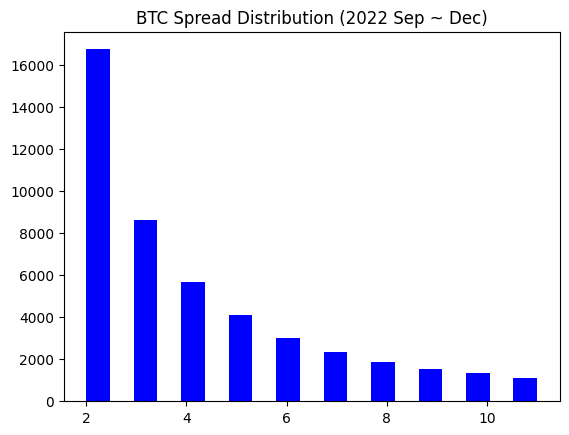

In [239]:
unit_spread = df.ba_spread.min()
spread = round(df.ba_spread/unit_spread).to_frame()

# truncate values which goes over 99.9%ile and cut values below 2.
spread_trunc = spread[
                            (spread.ba_spread < spread.ba_spread.quantile(0.999)) &
                            (spread.ba_spread > 1)
                        ]
plt.hist(spread_trunc.values, bins=19, color='blue')
plt.title('BTC Spread Distribution (2022 Sep ~ Dec)')
plt.savefig('BTC_spread_dist.png')

In [240]:
# ratio of spread 1s
print(spread[spread.ba_spread <= 4].shape[0]/spread.shape[0])

# maximum spreads
print(spread.max())

0.9974765625
ba_spread    2341.0
dtype: float64


In [241]:
mid_chg = round(df[['mid_price']].diff().div(0.001))

# mid price change frequency
print(mid_chg[mid_chg.values != 0].shape[0]/mid_chg.shape[0] * 100)

# mid price change maximum magnitude
print(abs(mid_chg).max())

30.44472415123457
mid_price    324750.0
dtype: float64


In [253]:
df[(spread > 4).values].mid_chg.max(), df[(spread <= 4).values].mid_chg.max()

(246.90000000000146, 142.04999999999927)

In [254]:
df[(spread > 4).values].mid_chg.min(), df[(spread <= 4).values].mid_chg.min()

(-324.75, -177.5)

<AxesSubplot: >

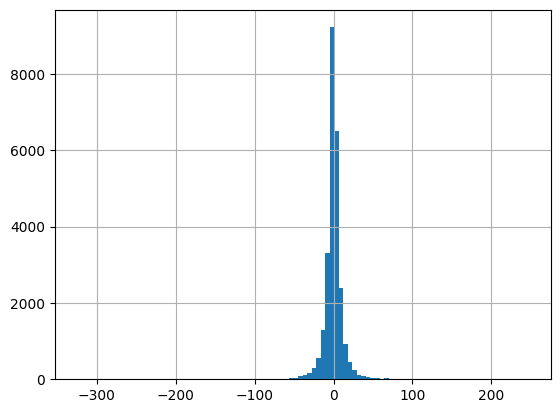

In [251]:
df[(spread > 4).values].mid_chg.hist(bins=100)

# ETH Spread distribution

- Ratio of discretized spread less than or equal to 4: 99.5%
- Maximum spread: 1896

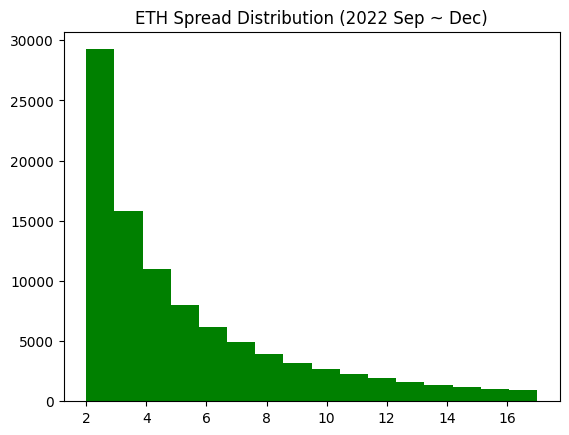

In [256]:
unit_spread = df.ba_spread.min()
spread = round(df.ba_spread/unit_spread).to_frame()

# truncate values which goes over 99.9%ile and cut values below 2.
spread_trunc = spread[
                            (spread.ba_spread < spread.ba_spread.quantile(0.999)) &
                            (spread.ba_spread > 1)
                        ]
plt.hist(spread_trunc.values, bins=16, color='green')
plt.title('ETH Spread Distribution (2022 Sep ~ Dec)')
plt.savefig('ETH_spread_dist.png')

In [226]:
# ratio of spread 1s
print(spread[spread.ba_spread <= 4].shape[0]/spread.shape[0])

# maximum spreads
print(spread.max())

0.9951983024691358
ba_spread    1896.0
dtype: float64


In [227]:
mid_chg = round(df[['mid_price']].diff().div(0.001))

# mid price change frequency
print(mid_chg[mid_chg.values != 0].shape[0]/mid_chg.shape[0] * 100)

# mid price change maximum magnitued
print(abs(mid_chg).max())

42.72679398148148
mid_price    36265.0
dtype: float64


In [257]:
df[(spread > 4).values].mid_chg.max(), df[(spread <= 4).values].mid_chg.max()

(33.805000000000064, 16.20999999999981)

In [258]:
df[(spread > 4).values].mid_chg.min(), df[(spread <= 4).values].mid_chg.min()

(-36.26499999999987, -14.014999999999873)

# ADA Spread distribution

- Ratio of discretized spread less than or equal to 4: 99.99%
- Maximum spread: 42

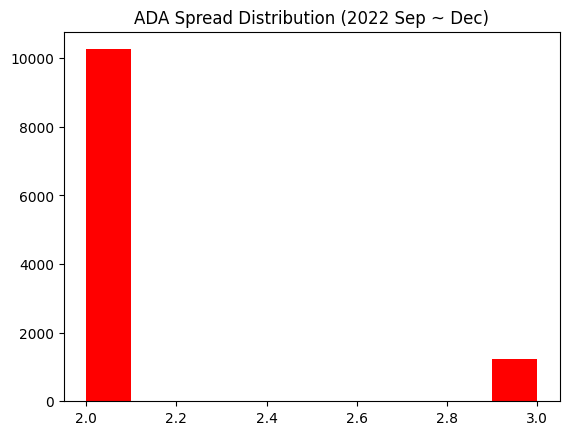

In [163]:
unit_spread = df.ba_spread.min()
spread = round(df.ba_spread/unit_spread).to_frame()

# truncate values which goes over 99.9%ile and cut values below 2.
spread_trunc = spread[
                            (spread.ba_spread < spread.ba_spread.quantile(0.9999)) &
                            (spread.ba_spread > 1)
                        ]
plt.hist(spread_trunc.values, bins=10, color='red')
plt.title('ADA Spread Distribution (2022 Sep ~ Dec)')
plt.savefig('ADA_spread_dist.png')

In [162]:
# ratio of spread 1s
print(spread[spread.ba_spread <= 4].shape[0]/spread.shape[0])

# maximum spreads
print(spread.max())

0.9999301697530865
ba_spread    42.0
dtype: float64


In [220]:
mid_chg = round(df[['mid_price']].diff().div(0.001))

# mid price change frequency
print(mid_chg[mid_chg.values != 0].shape[0]/mid_chg.shape[0] * 100)

# mid price change maximum magnitued
print(abs(mid_chg).max())

0.0513792438271605
mid_price    9.0
dtype: float64


In [259]:
from src.preprocessing import extract_features, symmetrize_data

In [260]:
quote_btc = sorted(glob.glob(RAW_DATA_PATH + 'btcusdt/orderbook/*.csv.gz'))

In [262]:

# extract raw data
all_features = [
    extract_features(path) for path in quote_btc[:5]
]
df_feat = dask.compute(all_features)[0]
df_feat = pd.concat(df_feat)

# symmetrized data (for obtaining microprice)
df_sym = symmetrize_data(df_feat, symmetrize=True)

In [263]:
df_sym

,mid_price,ba_spread,imbalance,mid_chg,next_ba_spread,next_imbalance
timestamp,,,,,,
2022-09-02 00:00:00,20122.55,1,1,0.0,1,1
2022-09-02 00:00:01,20122.55,1,1,0.0,1,1
2022-09-02 00:00:03,20120.75,1,1,0.0,1,4
2022-09-02 00:00:08,20124.85,1,4,0.0,1,3
2022-09-02 00:00:09,20124.85,1,3,0.0,1,3
...,...,...,...,...,...,...
2022-09-06 23:59:48,18779.95,1,4,-0.0,1,4
2022-09-06 23:59:49,18779.95,1,4,-0.2,1,1
2022-09-06 23:59:51,18780.55,1,1,-0.0,1,2
